# <HR> Home Assignment - 4 <HR>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = 'data_4/'

In [3]:
data = pd.read_csv(DATA_PATH + 'telecom_data.csv', index_col=['index'])
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data_copy = data.copy(deep=True)

In [4]:
data.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
index,,,,,,,,,,,,,,,,,,,,,
7037,2569-WGERO,Female,No,No,No,72,Yes,No,No,No,...,No,No,No,No,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No
7038,6840-RESVB,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7041,8361-LTMKD,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,No,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


## Task-1 Data preprocessing

In [5]:
bins = pd.IntervalIndex.from_tuples(
    [(0, 12), (12, 24), (24, 36), (36,48), (48,60), (60,float("inf"))], closed='left')
data['tenure_group'] = pd.cut(data.tenure, bins)
data.groupby(['tenure_group']).tenure_group.count()

tenure_group
[0.0, 12.0)     1573
[12.0, 24.0)     844
[24.0, 36.0)     719
[36.0, 48.0)     670
[48.0, 60.0)     775
[60.0, inf)     1462
Name: tenure_group, dtype: int64

In [6]:
binary_cols = list(filter(lambda col: data[col].nunique()==2, data.columns))
for binary_col in binary_cols:
    data[binary_col] = LabelEncoder().fit_transform(data[binary_col])
len(binary_cols), binary_cols

(13,
 ['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'PaperlessBilling',
  'Churn'])

In [7]:
data = data.drop('customerID', axis=1)

In [8]:
temp = data.select_dtypes(exclude='number')
multi_values_cols = list(filter(lambda col: temp[col].nunique()>2, temp.columns))
len(multi_values_cols), multi_values_cols

(5,
 ['MultipleLines',
  'InternetService',
  'Contract',
  'PaymentMethod',
  'tenure_group'])

In [9]:
data = pd.concat([data, pd.get_dummies(data[multi_values_cols])], axis=1)
data = data.drop(data[multi_values_cols], axis=1)

## Task-2 Build a churn model

In [10]:
X = data.drop('Churn', axis=1).to_numpy()
y = data.Churn.to_numpy()

In [11]:
#RandomForestClassifier
model_rf = RandomForestClassifier(random_state=2020)
y_true, y_prob, y_pred = np.empty((0,)), np.empty((0,)), np.empty((0,))
for train_index, test_index in KFold(n_splits=5).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_rf.fit(X_train, y_train)
    y_prob = np.concatenate([y_prob, model_rf.predict_proba(X_test)[:,1]])
    y_pred = np.concatenate([y_prob, model_rf.predict(X_test)])
    y_true = np.concatenate([y_true, y_test])
roc_auc_score(y_true, y_prob).round(2)

0.92

In [12]:
#LogisticRegression
model_lr = LogisticRegression(max_iter=500)
y_true, y_prob, y_pred = np.empty((0,)), np.empty((0,)), np.empty((0,))
for train_index, test_index in KFold(n_splits=5).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_lr.fit(X_train, y_train)
    y_prob = np.concatenate([y_prob, model_lr.predict_proba(X_test)[:,1]])
    y_pred = np.concatenate([y_pred, model_lr.predict(X_test)])
    y_true = np.concatenate([y_true, y_test])
roc_auc_score(y_true, y_prob).round(2)

0.93

## Task-2 Compare two discount strategies
    Strategy A: Provide a 20% discount with a 75% acceptance rate.
    Strategy B: Provide a 30% discount with a 90% acceptance rate.

##### Section-1 Use the default threshold of 0.5 to compute the confusion matrix.

In [13]:
tp, fn, fp, tn = confusion_matrix(y_true, y_pred, labels=[1,0]).ravel()
tp, fn, fp, tn =1426, 443, 219, 3955

In [14]:
p = data.MonthlyCharges.mean()

###### 2.2 Losses if you do not apply any discount strategy.

In [15]:
round((tp + fn) * p, 2)

117481.16

###### 2.3 Total gains from the discount strategy B

In [16]:
gain = round(tp * 0.9 * p)
gain

80672

###### 2.4 Total costs of the discount strategy B.

In [17]:
cost = round((tp + fp) * 0.3 * p, 2)
cost

31020.31

###### 2.5 Total losses of the discount strategy B.

In [18]:
loss = round(fn * p + tp * (1-0.9) * (1-0.3) * p, 2)
loss

34120.45

###### 2.6 Total profit of the discount strategy B.

In [19]:
profit = gain - cost - loss
round(profit, 2)

15531.24

###### 2.7 Profit per customer p_d (using strategy B). 

In [20]:
total_uncharned = 0.9*tp + fp + tn
p_d = round(profit/total_uncharned, 2)
p_d

2.85

##### Section-2 Use 9 different thresholds: 0.1, 0.2, … 0.9

In [21]:
accuracies = []
profits = []
profits_pc = []
for threshold in np.arange(0.1,1,0.1):
    new_y_pred = (y_prob > threshold).astype(int)
    accuracy = accuracy_score(y_true, new_y_pred)
    accuracies.append((threshold, accuracy))
    tp, fn, fp, tn = confusion_matrix(y_true, new_y_pred, labels=[1,0]).ravel()
    
    #Strategy-B
    gain = tp * 0.9 * p 
    loss = fn * p + tp * (1-0.9) * (1-0.3) * p
    cost = (tp + fp) * 0.3 * p
    profit = gain-cost-loss
    profits.append((threshold, profit))
    total_uncharned = 0.9*tp + fp + tn
    profits_pc.append((threshold, profit/total_uncharned))
    

###### 2.8 What is the threshold with the highest accuracy, using strategy B?

In [22]:
max(accuracies, key=lambda x:x[1])[0]

0.6

###### 2.9 What is the threshold with the highest profit, using strategy B?

In [23]:
max(profits, key=lambda x:x[1])[0]

0.2

###### 2.10 What is the highest profit, using strategy B?

In [24]:
max(profits, key=lambda x:x[1])[1].round(2)

23560.35

###### 2.11 What is the threshold with the highest profit per customer, using strategy B ?

In [25]:
max(profits_pc, key=lambda x:x[1])[0]

0.2

###### 2.12 What is the highest profit per customer, using strategy B ?

In [26]:
max(profits_pc, key=lambda x:x[1])[1].round(2)

4.15

###### 2.13 What is the ratio of profit per customer (obtained on the previous step) and p? p_d / p

In [27]:
round((p_d/ p),2)

0.05

###### 2.14 Which strategy yields the highest profit (A or B)?

In [28]:
def get_details(accp_rate, discount):
    res = []
    for threshold in np.arange(0.1,1,0.1):
        info = {}
        new_y_pred = (y_prob > threshold).astype(int)
        accuracy = accuracy_score(y_true, new_y_pred)
        tp, fn, fp, tn = confusion_matrix(y_true, new_y_pred, labels=[1,0]).ravel()
        
        #Strategy
        gain = tp * accp_rate * p 
        loss = fn * p + tp * (1-accp_rate) * (1-discount) * p
        cost = (tp + fp) * discount * p
        profit = gain-cost-loss
        total_uncharned = accp_rate*tp + fp + tn
        profit_pc =  profit/total_uncharned
        
        info['threshold'] = threshold
        info['accuracy'] = accuracy
        info['Conf'] = (tp, fn, fp, tn)
        info['profit'] = profit
        info['profit_pc'] = profit_pc
        
        res.append(info)
    return res

In [29]:
#Strategy-A at different threshold
A_result = get_details(0.75, 0.2)

#Strategy-B at different threshold
B_result= get_details(0.9, 0.3)

In [30]:
(max(A_result, key=lambda x:x['profit'])['profit'], 
max(B_result, key=lambda x:x['profit'])['profit'])
#Strategy-B

(12338.978493298026, 23560.345995201067)

###### 2.15 What are the TP, FP, TN, FN in this case? 

In [31]:
#tp, fn, fp, tn
max(B_result, key=lambda x:x['profit'])['Conf']

(1664, 205, 1007, 3167)

###### 2.16 What is the highest profit in that case?

In [32]:
max(B_result, key=lambda x:x['profit'])['profit'].round(2)

23560.35

###### 2.17 Which strategy yields the highest profit per customer (A or B)? 

In [33]:
(max(A_result, key=lambda x:x['profit_pc'])['profit_pc'], 
max(B_result, key=lambda x:x['profit_pc'])['profit_pc'])
#Strategy-B

(2.2489708362887133, 4.154091613513129)

###### 2.18 What are the TP, FP, TN, FN in this case? 

In [34]:
#tp, fn, fp, tn
max(B_result, key=lambda x:x['profit_pc'])['Conf']

(1664, 205, 1007, 3167)

###### 2.19 What is the highest profit in that case?

In [35]:
max(B_result, key=lambda x:x['profit_pc'])['profit_pc'].round(2)

4.15

## Report

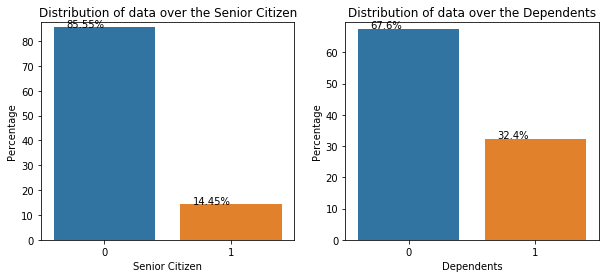

In [36]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches((10,4))
for i, (title, x) in enumerate([('Senior Citizen',data.SeniorCitizen),('Dependents', data.Dependents)]):
    ax[i].set_title("Distribution of data over the "+title)
    sns.countplot(x = x, ax = ax[i])
    ax[i].set_xlabel(title)
    ax[i].set_ylabel('Percentage')
    norm_fac = len(x)
    ylim = 0
    for pp in ax[i].patches:
        pp.set_height(pp.get_height()*100/norm_fac)
        txt = str(pp.get_height().round(2))+'%'
        txt_x,txt_y = pp.get_x()+0.1, pp.get_height()
        ax[i].text(txt_x, txt_y, txt)
        ylim = max(ylim, pp.get_height())+1
    ax[i].set_ylim(0,ylim)
plt.show()

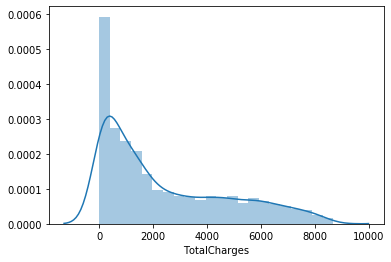

In [37]:
sns.distplot(data.TotalCharges)

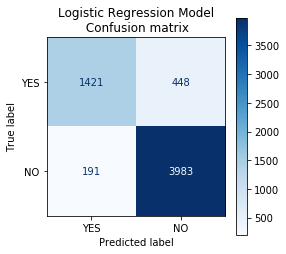

In [38]:
from sklearn.metrics import plot_confusion_matrix
class_names = ['YES', 'NO']
fig, ax = plt.subplots(figsize=(4, 4))
disp = plot_confusion_matrix(model_lr, X, y,
                             values_format='d',
                             display_labels=class_names,
                             labels=[1,0],
                             cmap=plt.cm.Blues,
                             ax=ax)
disp.ax_.set_title("Logistic Regression Model\n Confusion matrix")
plt.show()

###### Do thresholds for the highest profit and highest profit per customer coincide or not? Why? 

In [39]:
(max(A_result,key=lambda x:x['profit'])['threshold'], 
max(A_result,key=lambda x:x['profit_pc'])['threshold'])

(0.1, 0.1)

In [40]:
(max(B_result,key=lambda x:x['profit'])['threshold'], 
max(B_result,key=lambda x:x['profit_pc'])['threshold'])

(0.2, 0.2)

Which you decide to choose? Under what circumstances (how many clients will you lose in both situations; what should be the decision criteria)?

In [41]:
columns = ['Threshold', 'Count of Churned Client']
stra_A = pd.DataFrame([[i['threshold'], int(i['Conf'][0]*0.25 +i['Conf'][0])]  for i in A_result], columns=columns).set_index('Threshold')
stra_B = pd.DataFrame([[i['threshold'], int(i['Conf'][0]*0.1 +i['Conf'][0])]  for i in B_result], columns=columns).set_index('Threshold')
stra_A

,Count of Churned Client
Threshold,
0.1,2187
0.2,2080
0.3,1961
0.4,1881
0.5,1782
0.6,1675
0.7,1545
0.8,1383
0.9,1093


## Bonus

##### Section-1 Use the default threshold of 0.5 to compute the confusion matrix.

In [42]:
tp, fn, fp, tn = confusion_matrix(y_true, y_pred, labels=[1,0]).ravel()
tp, fn, fp, tn

(1426, 443, 219, 3955)

In [43]:
#monthly charges for tp, fn, fp, tn
tp_MCs = data.iloc[np.argwhere((y_pred==1) & (y_true==1)).reshape((-1,))].MonthlyCharges
fn_MCs = data.iloc[np.argwhere((y_pred==0) & (y_true==1)).reshape((-1,))].MonthlyCharges
fp_MCs = data.iloc[np.argwhere((y_pred==1) & (y_true==0)).reshape((-1,))].MonthlyCharges
tn_MCs = data.iloc[np.argwhere((y_pred==0) & (y_true==0)).reshape((-1,))].MonthlyCharges

###### 2.2 Losses if you do not apply any discount strategy.

In [44]:
round(tp_MCs.sum()+fn_MCs.sum(), 2)

139130.85

###### 2.3 Total gains from the discount strategy B

In [45]:
#90% from true positive
gain = tp_MCs.sample(frac=0.9, random_state=2020).sum()
gain

99769.4

###### 2.4 Total costs of the discount strategy B.

In [46]:
cost = (tp_MCs.sum()+fp_MCs.sum())*0.3
cost

37972.17

###### 2.5 Total losses of the discount strategy B.

In [47]:
loss = fn_MCs.sum() + tp_MCs.sample(frac=1-0.9, random_state=2020).sum() * (1-0.3)
loss

36012.560000000005

###### 2.6 Total profit of the discount strategy B.

In [48]:
profit = gain - cost - loss
profit.round(2)

25784.67

###### 2.7 Profit per customer p_d (using strategy B). 

In [49]:
total_uncharned = 0.9*tp + fp + tn
p_d = round(profit/total_uncharned, 2)
p_d

4.72

##### Section-2 Use 9 different thresholds: 0.1, 0.2, … 0.9

In [50]:
accuracies = []
profits = []
profits_pc = []
for threshold in np.arange(0.1,1,0.1):
    new_y_pred = (y_prob > threshold).astype(int)
    accuracy = accuracy_score(y_true, new_y_pred)
    accuracies.append((threshold, accuracy))
    tp, fn, fp, tn = confusion_matrix(y_true, new_y_pred, labels=[1,0]).ravel()

    #monthly charges for tp, fn, fp, tn
    tp_MCs = data.iloc[np.argwhere((y_pred==1) & (y_true==1)).reshape((-1,))].MonthlyCharges
    fn_MCs = data.iloc[np.argwhere((y_pred==0) & (y_true==1)).reshape((-1,))].MonthlyCharges
    fp_MCs = data.iloc[np.argwhere((y_pred==1) & (y_true==0)).reshape((-1,))].MonthlyCharges
    tn_MCs = data.iloc[np.argwhere((y_pred==0) & (y_true==0)).reshape((-1,))].MonthlyCharges
    
    #Strategy-B
    gain = tp_MCs.sample(frac=0.9, random_state=2020).sum()
    loss = fn_MCs.sum() + tp_MCs.sample(frac=1-0.9, random_state=2020).sum() * (1-0.3)
    cost = (tp_MCs.sum()+fp_MCs.sum())*0.3
    profit = gain-cost-loss
    profits.append((threshold, profit))
    total_uncharned = 0.9*tp + fp + tn
    profits_pc.append((threshold, profit/total_uncharned))

###### 2.8 What is the threshold with the highest accuracy, using strategy B?

In [51]:
max(accuracies, key=lambda x:x[1])[0]

0.6

###### 2.9 What is the threshold with the highest profit, using strategy B?

In [52]:
max(profits, key=lambda x:x[1])[0]

0.1

###### 2.10 What is the highest profit, using strategy B?

In [53]:
max(profits, key=lambda x:x[1])[1].round(2)

25784.67

###### 2.11 What is the threshold with the highest profit per customer, using strategy B ?

In [54]:
max(profits_pc, key=lambda x:x[1])[0]

0.9

###### 2.12 What is the highest profit per customer, using strategy B ?

In [55]:
max(profits_pc, key=lambda x:x[1])[1].round(2)

5.2

###### 2.13 What is the ratio of profit per customer (obtained on the previous step) and p? p_d / p

In [56]:
p_d / p

0.07509017059258609

###### 2.14 Which strategy yields the highest profit (A or B)?

In [57]:
def get_details(accp_rate, discount):
    res = []
    for threshold in np.arange(0.1,1,0.1):
        info = {}
        new_y_pred = (y_prob > threshold).astype(int)
        accuracy = accuracy_score(y_true, new_y_pred)
        tp, fn, fp, tn = confusion_matrix(y_true, new_y_pred, labels=[1,0]).ravel()
        
        #monthly charges for tp, fn, fp, tn
        tp_MCs = data.iloc[np.argwhere((y_pred==1) & (y_true==1)).reshape((-1,))].MonthlyCharges
        fn_MCs = data.iloc[np.argwhere((y_pred==0) & (y_true==1)).reshape((-1,))].MonthlyCharges
        fp_MCs = data.iloc[np.argwhere((y_pred==1) & (y_true==0)).reshape((-1,))].MonthlyCharges
        tn_MCs = data.iloc[np.argwhere((y_pred==0) & (y_true==0)).reshape((-1,))].MonthlyCharges

        #Strategy
        gain = tp_MCs.sample(frac=accp_rate, random_state=2020).sum()
        loss = fn_MCs.sum() + tp_MCs.sample(frac=1-accp_rate, random_state=2020).sum() * (1-discount)
        cost = (tp_MCs.sum()+fp_MCs.sum())*discount
        profit = gain-cost-loss
        total_uncharned = accp_rate*tp + fp + tn
        profit_pc = profit/total_uncharned
        
        info['threshold'] = threshold
        info['accuracy'] = accuracy
        info['Conf'] = (tp, fn, fp, tn)
        info['Conf_Monthly'] = (tp_MCs, fn_MCs, fp_MCs, tn_MCs)
        info['profit'] = profit
        info['profit_pc'] = profit_pc
        res.append(info)
        
    return res

In [58]:
#Strategy-A at different threshold
A_result = get_details(0.75, 0.2)

#Strategy-B at different threshold
B_result= get_details(0.9, 0.3)

In [59]:
(max(A_result, key=lambda x:x['profit'])['profit'], 
max(B_result, key=lambda x:x['profit'])['profit'])
#Strategy-B

(7676.929999999993, 25784.66999999999)

###### 2.15 What are the TP, FP, TN, FN in this case? 

In [60]:
#tp, fn, fp, tn
max(B_result, key=lambda x:x['profit'])['Conf']

(1750, 119, 1486, 2688)

###### 2.16 What is the highest profit in that case?

In [61]:
max(B_result, key=lambda x:x['profit'])['profit']

25784.66999999999

###### 2.17 Which strategy yields the highest profit per customer (A or B)? 

In [62]:
(max(A_result, key=lambda x:x['profit_pc'])['profit_pc'], 
max(B_result, key=lambda x:x['profit_pc'])['profit_pc'])
#Strategy-B

(1.5893442368407418, 5.196950518996269)

###### 2.18 What are the TP, FP, TN, FN in this case? 

In [63]:
#tp, fn, fp, tn
max(B_result, key=lambda x:x['profit_pc'])['Conf']

(875, 994, 0, 4174)

###### 2.19 What is the highest profit in that case?

In [64]:
max(B_result, key=lambda x:x['profit_pc'])['profit_pc']

5.196950518996269

#### Report

###### Do thresholds for the highest profit and highest profit per customer coincide or not? Why? 

In [65]:
(max(A_result,key=lambda x:x['profit'])['threshold'], 
max(A_result,key=lambda x:x['profit_pc'])['threshold'])

(0.1, 0.9)

In [66]:
(max(B_result,key=lambda x:x['profit'])['threshold'], 
max(B_result,key=lambda x:x['profit_pc'])['threshold'])

(0.1, 0.9)

Which you decide to choose? Under what circumstances (how many clients will you lose in both situations; what should be the decision criteria)?

In [67]:
columns = ['Threshold', 'Count of Churned Client']
stra_A = pd.DataFrame([[i['threshold'], int(i['Conf'][0]*0.25 +i['Conf'][0])]  for i in A_result], columns=columns).set_index('Threshold')
stra_B = pd.DataFrame([[i['threshold'], int(i['Conf'][0]*0.1 +i['Conf'][0])]  for i in B_result], columns=columns).set_index('Threshold')
stra_B

,Count of Churned Client
Threshold,
0.1,1925
0.2,1830
0.3,1725
0.4,1655
0.5,1568
0.6,1474
0.7,1359
0.8,1217
0.9,962


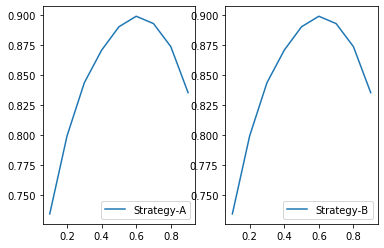

In [68]:
fig, ax = plt.subplots(1,2)
sns.lineplot([i['threshold'] for i in A_result],[i['accuracy'] for i in A_result], ax=ax[0], label="Strategy-A")
sns.lineplot([i['threshold'] for i in A_result],[i['accuracy'] for i in B_result], ax=ax[1], label="Strategy-B")

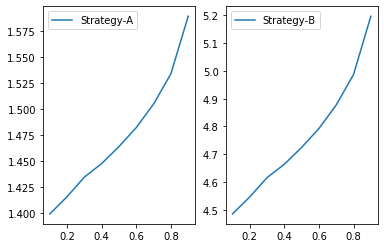

In [69]:
fig, ax = plt.subplots(1,2)
sns.lineplot([i['threshold'] for i in A_result],[i['profit_pc'] for i in A_result], ax=ax[0], label="Strategy-A")
sns.lineplot([i['threshold'] for i in A_result],[i['profit_pc'] for i in B_result], ax=ax[1], label="Strategy-B")